# Homework #4. Exploratory Data Analysis
Author: Sofiia Yeremeieva.
Total time spent on h/w (in minutes): 950

In [ ]:
import pandas as pd
from datetime import datetime
import glob
import re
import matplotlib.pyplot as plt
import json
import openai
import spacy

from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
from nltk import FreqDist

from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

In [5]:
all_text = pd.DataFrame(columns=['message', 'date'])

In [6]:
for file in glob.glob("channels/*.csv"):
    try:
        data = pd.read_csv(file, low_memory=False)

        data['date'] = data['date'].agg(datetime.fromisoformat)
        data['date'] = data['date'].apply(lambda x: x.date())

        all_text = pd.concat([all_text, data[['message', 'date']]], ignore_index=True)
    except Exception as e:
        print(f"An unexpected error occurred while processing {file}: {e}")

An unexpected error occurred while processing channels/rybar.csv: 'date'


In [ ]:
all_text['message'] = all_text['message'].astype(str)

In [ ]:
all_text.head(3)

,message,date
0,Байден подписал оборонный бюджет на 2023 финан...,2022-12-23
1,"Главные новости к вечеру пятницы, 23 декабря. ...",2022-12-23
2,Путин в Тульской области посетил конструкторск...,2022-12-23


In [ ]:
all_text.shape

(8108693, 2)

## Words and messages analysis of length, frequency and sentiments

This analysis provides a multifaceted view of propaganda content, from structural intricacies to thematic elements and emotional nuances, contributing to a comprehensive understanding of propagandist strategies.

Counting the length of messages provides insights into the depth and complexity of propaganda narratives. Longer messages may indicate more elaborate manipulation strategies, while shorter ones may rely on concise, impactful content.

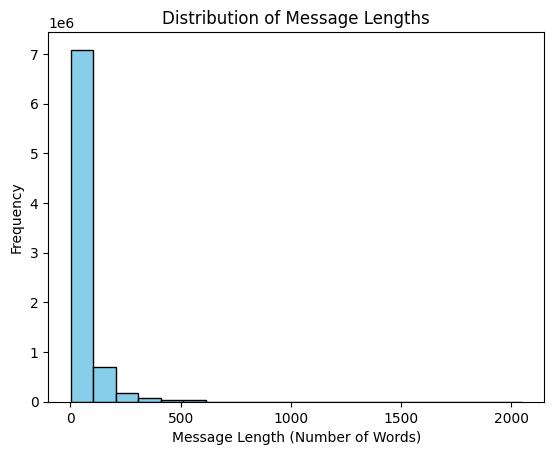

In [ ]:
message_lengths = [len(message.split()) for message in all_text['message']]

plt.hist(message_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Message Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Message Lengths')
plt.show()

Examining frequent words is valuable for identifying key themes and propaganda motifs. These recurring terms unveil the propagandist's focus and emphasize the topics intended to influence the audience. Understanding these themes aids in decoding the overarching narrative and ideological objectives.

Top 10 Most Common Words:


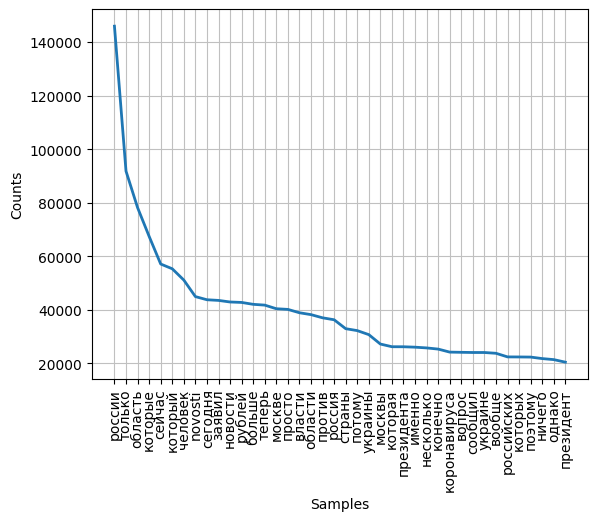

In [ ]:
tokenizer = RegexTokenizer()

def analyze_word_frequency(messages):
    words = [word[0].lower() for message in messages for word in tokenizer.split(message) if len(word[0])>5]
    word_freq = FreqDist(words)

    print("Top 10 Most Common Words:")
    word_freq.plot(40, cumulative=False)

analyze_word_frequency(all_text['message'][:1000000])

Sentiment analysis, assessing the emotional tone of messages, is pivotal for comprehending how propaganda aims to shape public perception. Detecting positive or negative sentiments helps gauge the intended emotional impact on the audience, offering a nuanced understanding of the propagandist's persuasive tactics.

In [ ]:
def analyze_sentiment(message):
  model = FastTextSocialNetworkModel(tokenizer=tokenizer)
  messages = [message]
  results = model.predict(messages, k=2)

  for message, sentiment in zip(messages, results):
    return max(sentiment, key=lambda k: sentiment[k])

In [ ]:
tokenizer = RegexTokenizer()

sentim = {"positive": 0, 'negative': 0, 'neutral': 0}

for message in all_text['message'][:10000]:
    sentiment = analyze_sentiment(message)
    if sentiment == 'skip' or sentiment == 'speech':
      continue
    sentim[sentiment] += 1

Text(0.5, 1.0, 'Distribution of Sentiments')

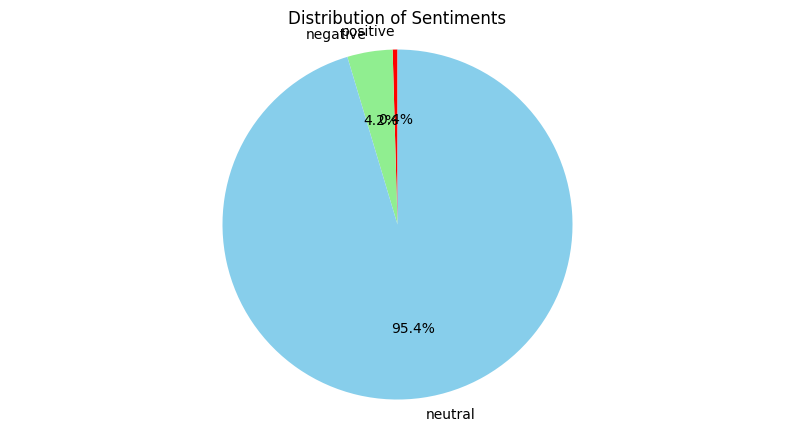

In [ ]:
plt.figure(figsize=(10, 5))

labels1 = sentim.keys()
sizes1 = sentim.values()
colors1 = ['red', 'lightgreen', 'skyblue']
plt.pie(sizes1, labels=labels1, colors=colors1, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Sentiments')

## Name-calling propaganda technique

The name-calling technique is very literal. Propaganda that utilizes this technique uses insults to call out the perceived deficits of the competition or the opposing side. This name-calling can resort to the use of stereotypes and slurs.

Words we will analyse as name-сallings:
- фашисти
- хохли
- бандерівці
- укронацисти
 - укрофашисти
- київський режим
- азов
- хунта

Proper names:
- українці

In [ ]:
names = {'нацист[a-я]+':0, 'фашист[a-я]+':0, 'хохл[a-я]+':0, 'бандер[a-я]+':0, 'укронац[a-я]+':0,
         'укрофаш[a-я]+':0, 'киевск[a-я]+ режим[a-я]+':0, 'азов[a-я][a-я]':0, 'хунт[a-я]+':0, 'украинц[a-я]+':0}


for i in range(len(all_text)):
    message = all_text.iloc[i]['message']

    for key in names:
        found = len(re.findall(fr'{key}', message.lower()))
        if found > 0:
            names[key] += found

On the plot we see frequences of the name-callings:

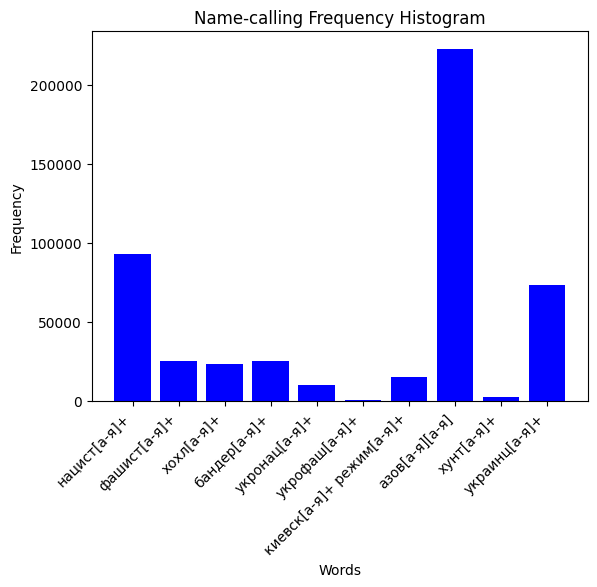

In [ ]:
plt.bar(names.keys(), names.values(), color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Name-calling Frequency Histogram')
plt.xticks(rotation=45, ha='right')
plt.show()

On this plot we look at overall number of callings vs proper name of the nation.

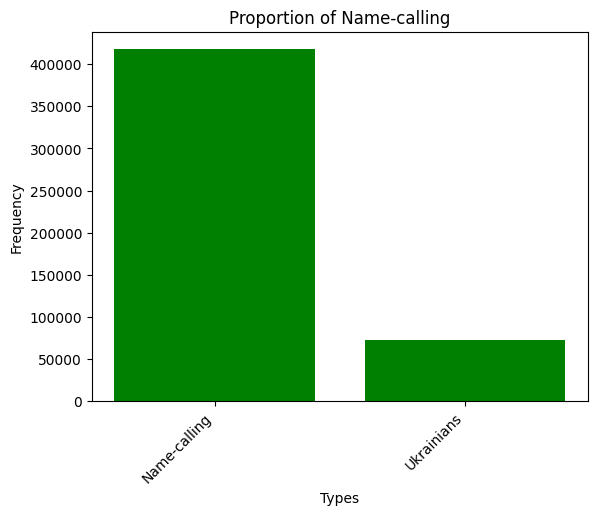

In [11]:
bad_names_sum = sum(list(names.values())[:-1])
good_names_sum = names['украинц[a-я]+']

labels = ['Name-calling', 'Ukrainians']
sizes = [bad_names_sum, good_names_sum]

plt.bar(labels, sizes, color='green')
plt.xlabel('Types')
plt.ylabel('Frequency')
plt.title('Proportion of Name-calling')
plt.xticks(rotation=45, ha='right')
plt.show()

and additional pie plot with percentages:

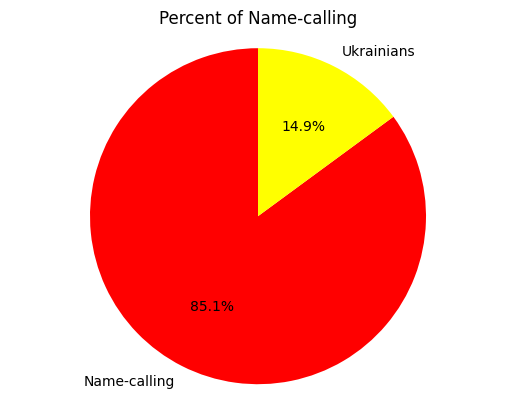

In [12]:
colors = ['red', 'yellow']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Percent of Name-calling')
plt.show()

## Analysis of Crucial Objects/News in Propaganda Messages Over Time

This section of the code is dedicated to examining the frequency of mentions of specific hot topics within propaganda messages throughout different months and years. The DataFrames contain crucial information such as the publication year, month, and the identified certain object/idea within each message.

In [13]:
zaes_data = {'year': [], 'month':[], 'number': []}

for i in range(len(all_text)):
    message = all_text.iloc[i]['message']

    pattern = r"(запорожск[а-я]+ атомн[а-я]+ электростанц[а-я]+|заэс)"
    found = re.findall(pattern, message.lower())

    if found:
      date_object = all_text.iloc[i]['date']
      zaes_data['year'].append(date_object.year)
      zaes_data['month'].append(date_object.month)
      zaes_data['number'].append(message)

zaes = pd.DataFrame(zaes_data)

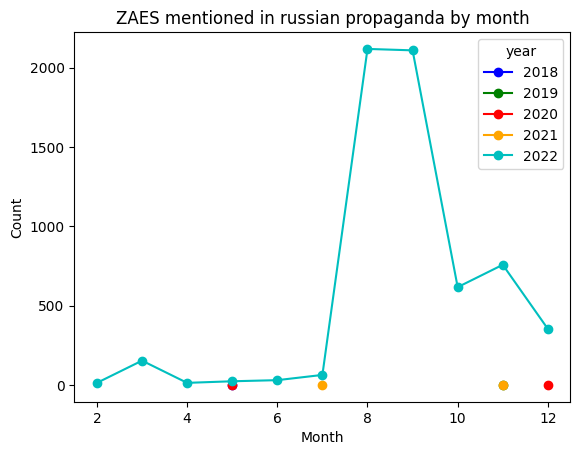

In [14]:
result = zaes.groupby(['year', 'month']).size().sort_values(ascending=True)
result = result.unstack('year')


result.plot(kind='line', marker='o', linestyle='-', color=['b', 'g', 'r', 'orange', 'c'])
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('ZAES mentioned in russian propaganda by month')
plt.show()

In [52]:
hes_data = {'year': [], 'month':[], 'number': []}

for i in range(len(all_text)):
    message = all_text.iloc[i]['message']

    pattern = r"(каховск[а-я]+ гидро[а-я]+ электростанц[а-я]+|каховск[а-я]+ гэс)"
    found = re.findall(pattern, message.lower())

    if found:
      date_object = all_text.iloc[i]['date']
      hes_data['year'].append(date_object.year)
      hes_data['month'].append(date_object.month)
      hes_data['number'].append(message)

hes = pd.DataFrame(hes_data)

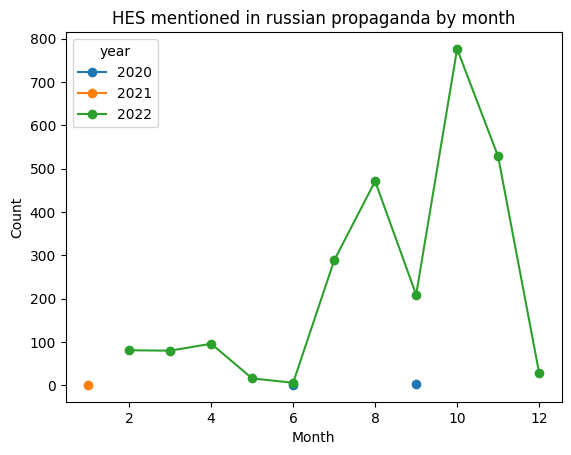

In [53]:
result = hes.groupby(['year', 'month']).size().sort_values(ascending=True)
result = result.unstack('year')


result.plot(kind='line', marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('HES mentioned in russian propaganda by month')
plt.show()

In [19]:
agr_data = {'year': [], 'month':[], 'number': []}

for i in range(len(all_text)):
    message = all_text.iloc[i]['message']

    pattern = r"(переговор[а-я]+)"
    found = re.findall(pattern, message.lower())

    if found:
      date_object = all_text.iloc[i]['date']
      agr_data['year'].append(date_object.year)
      agr_data['month'].append(date_object.month)
      agr_data['number'].append(message)

agr = pd.DataFrame(agr_data)

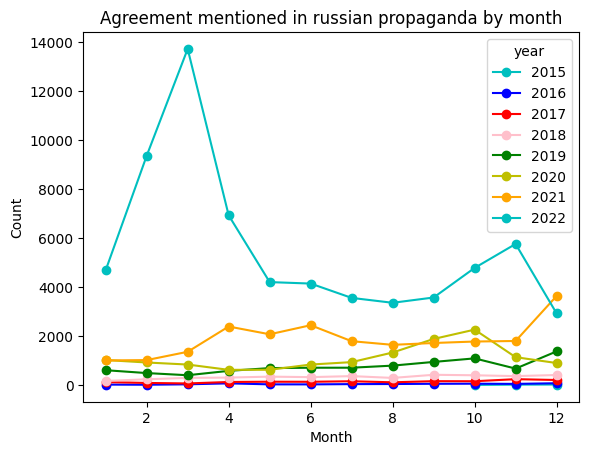

In [20]:
result = agr.groupby(['year', 'month']).size().sort_values(ascending=True)
result = result.unstack('year')


result.plot(kind='line', marker='o', linestyle='-', color=['c','b','r', 'pink', 'g', 'y', 'orange'])
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Agreement mentioned in russian propaganda by month')
plt.show()

In [ ]:
zel_data = {'year': [], 'month':[], 'number': []}

for i in range(len(all_text)):
    message = all_text.iloc[i]['message']

    pattern = r"(зеленск[а-я]+)"
    found = re.findall(pattern, message.lower())

    if found:
      date_object = all_text.iloc[i]['date']
      zel_data['year'].append(date_object.year)
      zel_data['month'].append(date_object.month)
      zel_data['number'].append(message)

zel = pd.DataFrame(zel_data)

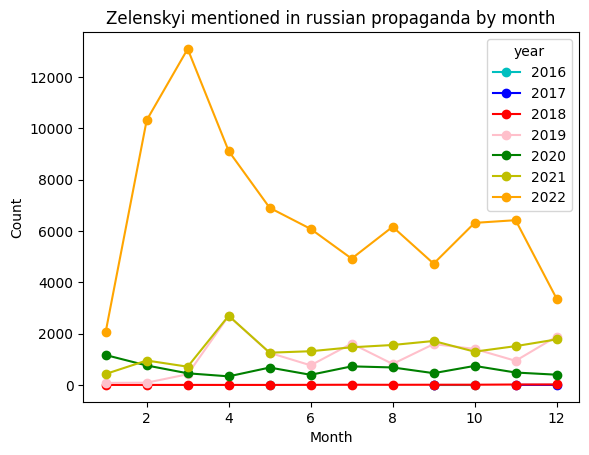

In [ ]:
result = zel.groupby(['year', 'month']).size().sort_values(ascending=True)
result = result.unstack('year')

result.plot(kind='line', marker='o', linestyle='-', color=['c','b','r', 'pink', 'g', 'y', 'orange'])
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Zelenskyi mentioned in russian propaganda by month')
plt.show()

In [ ]:
med_data = {'year': [], 'month':[], 'number': []}

for i in range(len(all_text)):
    message = all_text.iloc[i]['message']

    pattern = r"(медведчук[а-я]+)"
    found = re.findall(pattern, message.lower())

    if found:
      date_object = all_text.iloc[i]['date']
      med_data['year'].append(date_object.year)
      med_data['month'].append(date_object.month)
      med_data['number'].append(message)

med = pd.DataFrame(med_data)

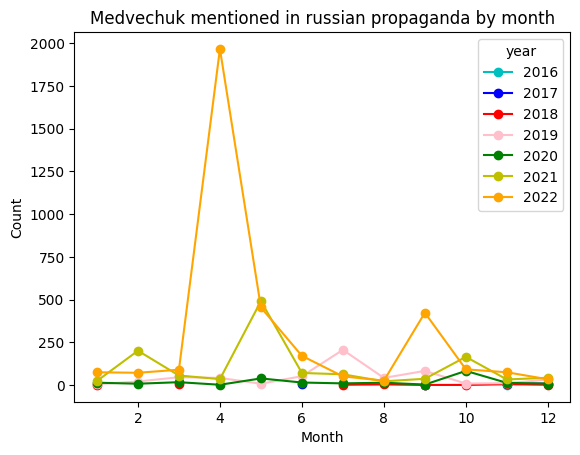

In [ ]:
result = med.groupby(['year', 'month']).size().sort_values(ascending=True)
result = result.unstack('year')

result.plot(kind='line', marker='o', linestyle='-', color=['c','b','r', 'pink', 'g', 'y', 'orange'])
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Medvechuk mentioned in russian propaganda by month')
plt.show()

In [ ]:
gor_data = {'year': [], 'month':[], 'number': []}

for i in range(len(all_text)):
    message = all_text.iloc[i]['message']

    pattern = r"(гордон[а-я]+)"
    found = re.findall(pattern, message.lower())

    if found:
      date_object = all_text.iloc[i]['date']
      gor_data['year'].append(date_object.year)
      gor_data['month'].append(date_object.month)
      gor_data['number'].append(message)

gor = pd.DataFrame(gor_data)

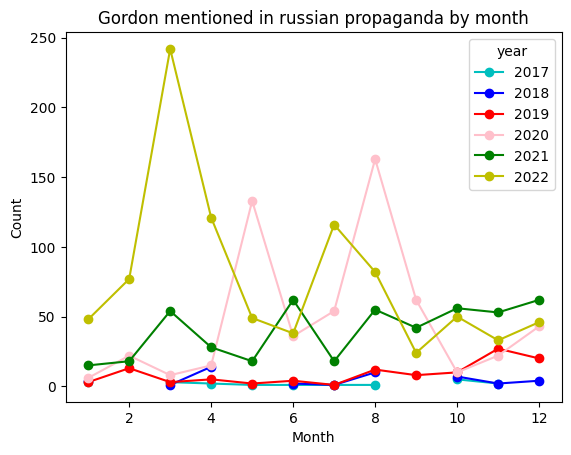

In [ ]:
result = gor.groupby(['year', 'month']).size().sort_values(ascending=True)
result = result.unstack('year')

result.plot(kind='line', marker='o', linestyle='-', color=['c','b','r', 'pink', 'g', 'y', 'orange'])
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Gordon mentioned in russian propaganda by month')
plt.show()

So huge result in March for Gordon can be connected with this beautiful video:
https://youtu.be/olgDR6nfA8M?si=czgwtywtH-OShuGf&t=143



## Analysing cities in Luhansk and Donetsk


Analysing cities in propaganda messages is crucial for understanding targeted geographic regions, tailoring messages to local sentiments, identifying regional hotspots, gauging public perception, and discerning strategic objectives. It provides insights into how propagandists shape narratives for specific audiences and helps grasp the broader impact on targeted populations.

In [21]:
donetsk_cities = [r"aвдеевк[а-я]+", r"aмвросиевк[а-я]+", r"aртемовск[а-я]+", r"aртемов[а-я]+", r"белицк[а-я]+", r"белозерск[а-я]+", r"волновах[а-я]+", r"углегорск[а-я]", r"угледар[а-я]+", r"горняк[а-я]+", r"горловк[а-я]+", r"дебальцев[а-я]+",
                  r"дзержинск[а-я]", r"димитров[а-я]", r"добропол[а-я]+", r"докучаевск[а-я]+", r"донецк[а-я]+", r"дружковк[а-я]+", r"енакиев[а-я]+", r"ждановк[а-я]+", r"зугрэс[а-я]+", r"иловайск[а-я]+", r"кировск[а-я]+", r"комсомольск[а-я]+",
                  r"константиновк[а-я]+", r"краматорск[а-я]+", r"красн[a-я]+ лиман[а-я]+", r"красноармейск[а-я]+", r"красногоровк[а-я]+", r"курахов[а-я]+", r"макеевка[а-я]+", r"марьинка[а-я]+", r"мариуполь[а-я]+", r"николаевка[а-я]+", r"моспино[а-я]+",
                  r"новоазовск[а-я]+", r"новогродовка[а-я]+", r"родинское[а-я]+", r"светлодарск[а-я]+", r"святогорск[а-я]+", r"северск[а-я]+", r"селидов[а-я]+", r"славянск[а-я]+", r"снежн[а-я]+", r"соледар[а-я]+", r"торез[а-я]+",
                  r"харцызск[а-я]+", r"часов[a-я]+ яр[а-я]+", r"шахтерск[а-я]+", r"юнокоммунаровск[а-я]+", r"ясиноватая[а-я]+"]

In [22]:
donetsk_data = pd.DataFrame(columns=['city', 'date'])

for i in range(len(all_text)):
    message = all_text.iloc[i]['message']

    for city_pattern in donetsk_cities:
        pattern = rf"({city_pattern})"
        found = re.findall(pattern, message.lower())

        if found:
            date_object = all_text.iloc[i]['date']
            donetsk_data = pd.concat([donetsk_data, pd.DataFrame({'city': [city_pattern], 'date': [date_object]})], axis=0)

donetsk_data.reset_index(drop=True, inplace=True)

<Figure size 1000x600 with 0 Axes>

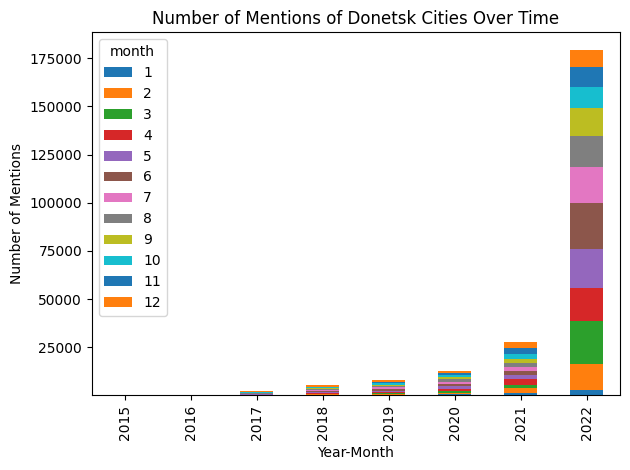

In [31]:
donetsk_data['date'] = pd.to_datetime(donetsk_data['date'])
donetsk_data['month'] = donetsk_data['date'].dt.month
donetsk_data['year'] = donetsk_data['date'].dt.year

plt.figure(figsize=(10, 6))
donetsk_data.groupby(['year', 'month'])['city'].count().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Year-Month')
plt.ylabel('Number of Mentions')
plt.title('Number of Mentions of Donetsk Cities Over Time')
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

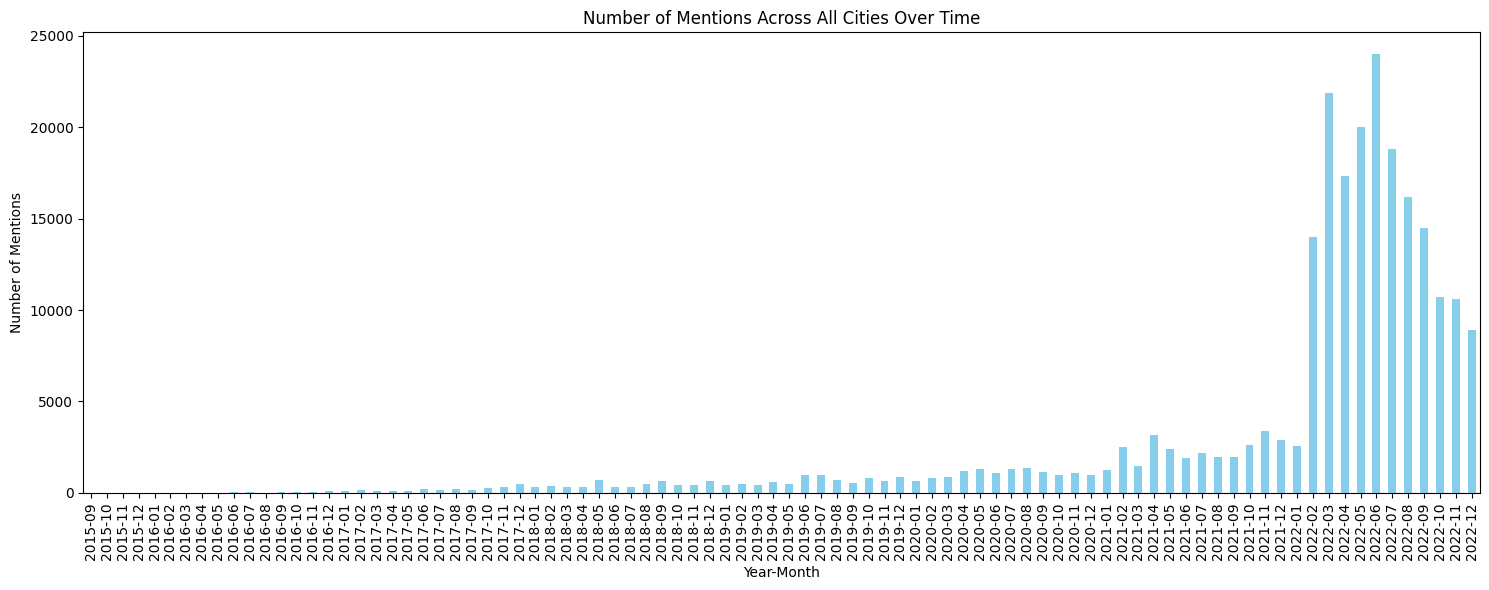

In [30]:
plt.figure(figsize=(15, 6))
donetsk_data.groupby(['year', 'month'])['city'].count().plot(kind='bar', color='skyblue')
plt.xlabel('Year-Month')
plt.ylabel('Number of Mentions')
plt.title('Number of Mentions Across All Cities Over Time')
unique_dates = sorted(donetsk_data.groupby(['year', 'month']).size().index)

plt.gca().set_xticks(range(len(unique_dates)))
plt.gca().set_xticklabels([f"{year}-{month:02d}" for year, month in unique_dates])

# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

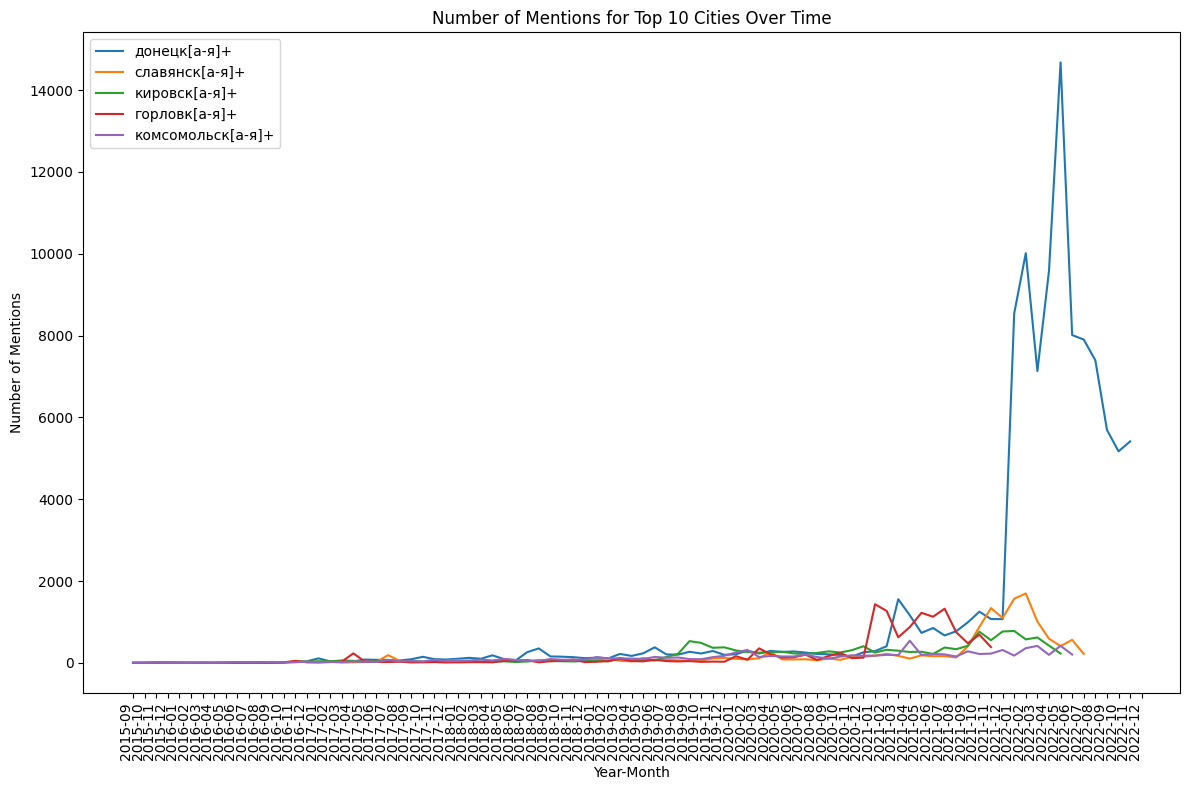

In [35]:
top_cities = donetsk_data['city'].value_counts().nlargest(15).index
top_cities_data = donetsk_data[donetsk_data['city'].isin(top_cities)]

plt.figure(figsize=(12, 8))
for city in top_cities[:5]:
    city_data = top_cities_data[top_cities_data['city'] == city]
    city_data.groupby(['year', 'month'])['city'].count().plot(label=city)

plt.xlabel('Year-Month')
plt.ylabel('Number of Mentions')
plt.title('Number of Mentions for Top 10 Cities Over Time')
plt.legend()
# plt.xticks(rotation=45, ha='right')

unique_dates = sorted(top_cities_data.groupby(['year', 'month']).size().index)
plt.gca().set_xticks(range(len(unique_dates)))
plt.gca().set_xticklabels([f"{year}-{month:02d}" for year, month in unique_dates])
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

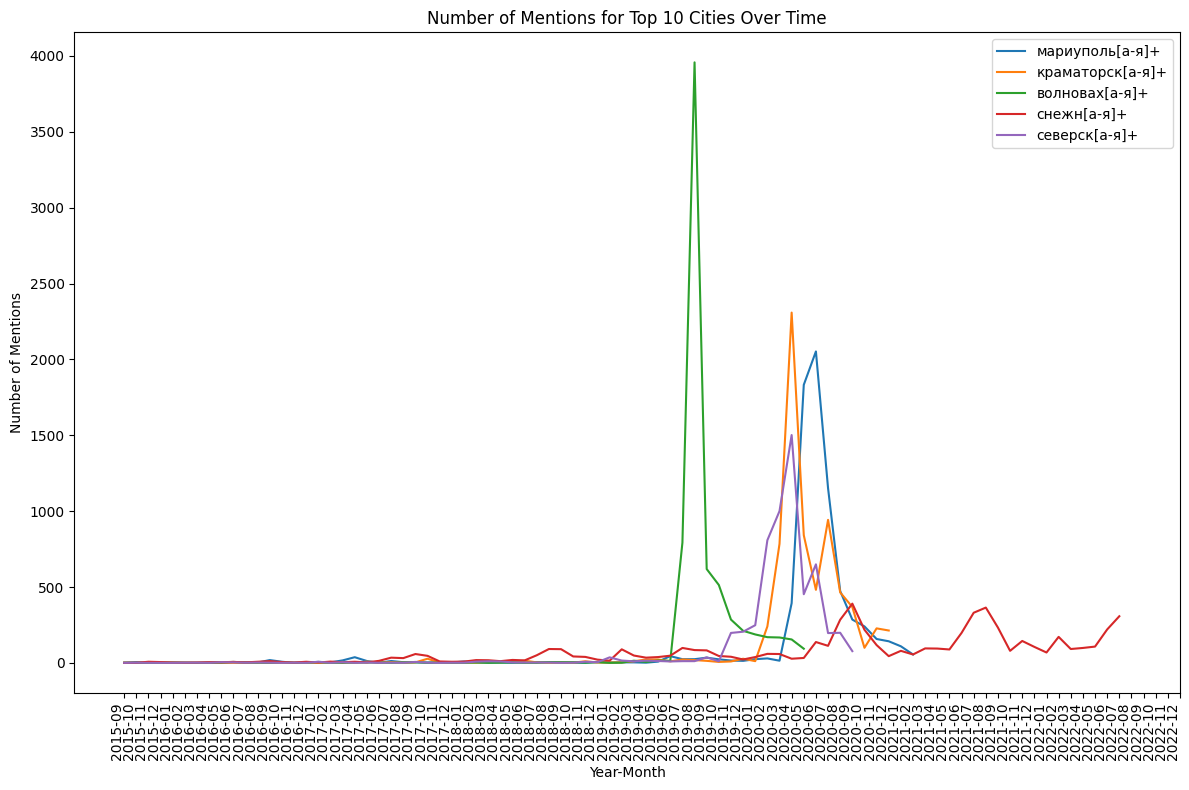

In [36]:
plt.figure(figsize=(12, 8))
for city in top_cities[5:10]:
    city_data = top_cities_data[top_cities_data['city'] == city]
    city_data.groupby(['year', 'month'])['city'].count().plot(label=city)

plt.xlabel('Year-Month')
plt.ylabel('Number of Mentions')
plt.title('Number of Mentions for Top 10 Cities Over Time')
plt.legend()


unique_dates = sorted(top_cities_data.groupby(['year', 'month']).size().index)
plt.gca().set_xticks(range(len(unique_dates)))
plt.gca().set_xticklabels([f"{year}-{month:02d}" for year, month in unique_dates])
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [54]:
luhansk_cities = [r"алмазн[а-я]+", r"алчевск[а-я]+", r"антрацит[а-я]+", r"артемовск[а-я]+", r"брянк[а-я]+", r"вахрушев[о-я]+", r"зимогор[a-я]+", r"золот[a-я]+", r"зоринск[а-я]+", r"ирмин[о-я]+", r"кировск[а-я]+",
                  r"красн[a-я]+ луч[а-я]+", r"краснодон[а-я]+", r"кременн[а-я]+", r"лисичанск[а-я]+", r"луганск[а-я]+", r"лутугин[а-я]+", r"миусинск[а-я]+", r"молодогвардейск[а-я]+", r"новодружеск[а-я]+", r"александровск[а-я]+",
                  r"первомайск[а-я]+", r"перевальск[а-я]+", r"петровск[а-я]+", r"попасн[а-я]+", r"привол[а-я]+", r"ровеньк[а-я]+", r"рубежн[а-я]+", r"сватов[а-я]+", r"свердловск[а-я]+", r"северодонецк[а-я]+", r"старобельск[а-я]+",
                  r"стаханов[а-я]+", r"суходольск[а-я]+", r"червонопартизанск[а-я]+"]

In [55]:
luhansk_data = pd.DataFrame(columns=['city', 'date'])

for i in range(len(all_text)):
    message = all_text.iloc[i]['message']

    for city_pattern in luhansk_cities:
        pattern = rf"({city_pattern})"
        found = re.findall(pattern, message.lower())

        if found:
            date_object = all_text.iloc[i]['date']
            luhansk_data = pd.concat([luhansk_data, pd.DataFrame({'city': [city_pattern], 'date': [date_object]})], axis=0)

luhansk_data.reset_index(drop=True, inplace=True)

<Figure size 1000x600 with 0 Axes>

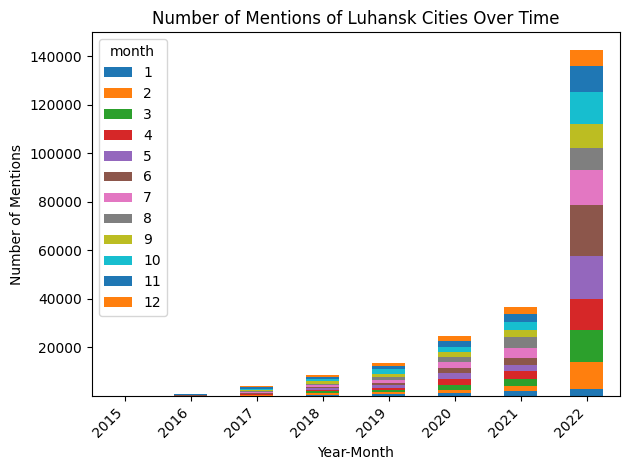

In [56]:
luhansk_data['date'] = pd.to_datetime(luhansk_data['date'])
luhansk_data['month'] = luhansk_data['date'].dt.month
luhansk_data['year'] = luhansk_data['date'].dt.year

plt.figure(figsize=(10, 6))
luhansk_data.groupby(['year', 'month'])['city'].count().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Year-Month')
plt.ylabel('Number of Mentions')
plt.title('Number of Mentions of Luhansk Cities Over Time')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

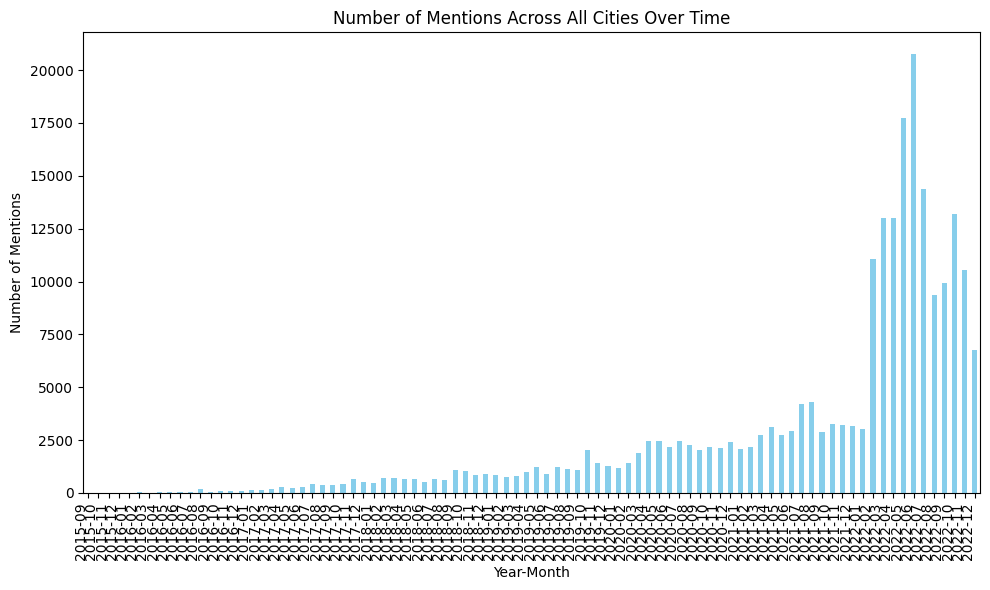

In [57]:
plt.figure(figsize=(10, 6))
luhansk_data.groupby(['year', 'month'])['city'].count().plot(kind='bar', color='skyblue')
plt.xlabel('Year-Month')
plt.ylabel('Number of Mentions')
plt.title('Number of Mentions Across All Cities Over Time')
unique_dates = sorted(luhansk_data.groupby(['year', 'month']).size().index)

plt.gca().set_xticks(range(len(unique_dates)))
plt.gca().set_xticklabels([f"{year}-{month:02d}" for year, month in unique_dates])

plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

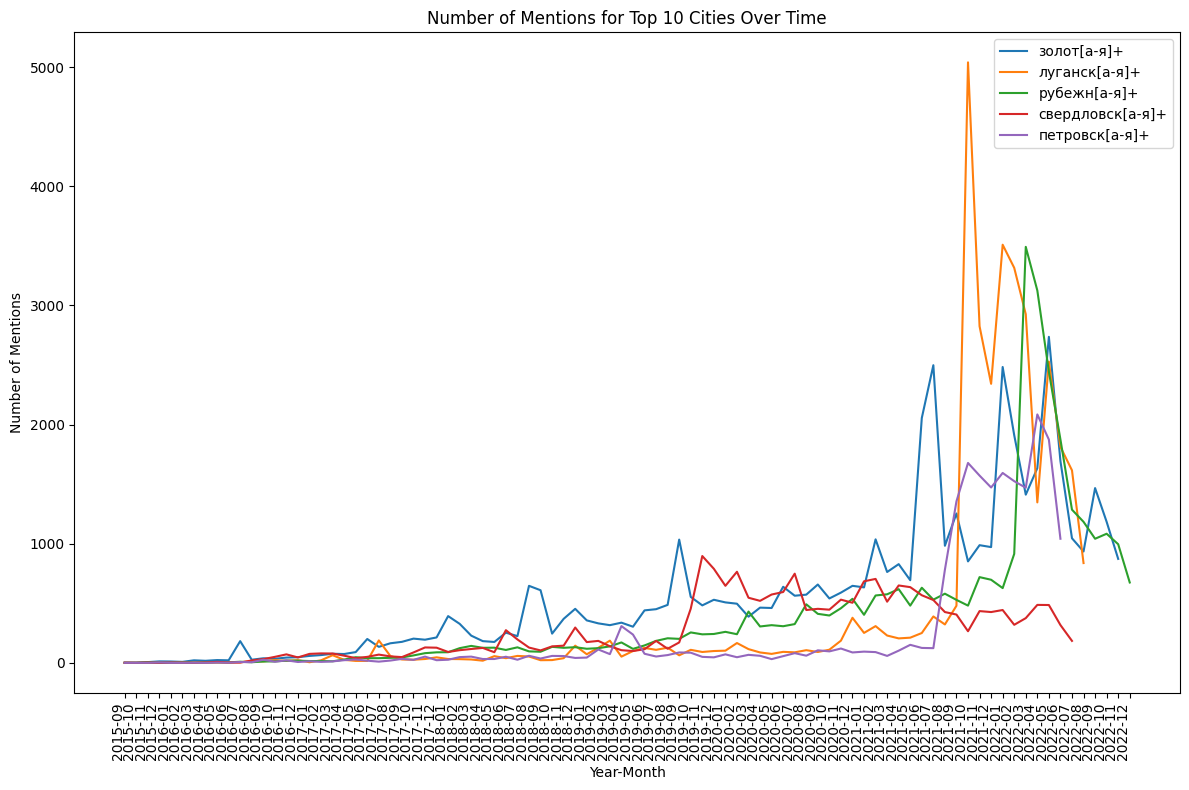

In [58]:
top_cities = luhansk_data['city'].value_counts().nlargest(15).index
top_cities_data = luhansk_data[luhansk_data['city'].isin(top_cities)]

plt.figure(figsize=(12, 8))
for city in top_cities[:5]:
    city_data = top_cities_data[top_cities_data['city'] == city]
    city_data.groupby(['year', 'month'])['city'].count().plot(label=city)

plt.xlabel('Year-Month')
plt.ylabel('Number of Mentions')
plt.title('Number of Mentions for Top 10 Cities Over Time')
plt.legend()

unique_dates = sorted(top_cities_data.groupby(['year', 'month']).size().index)
plt.gca().set_xticks(range(len(unique_dates)))
plt.gca().set_xticklabels([f"{year}-{month:02d}" for year, month in unique_dates])
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

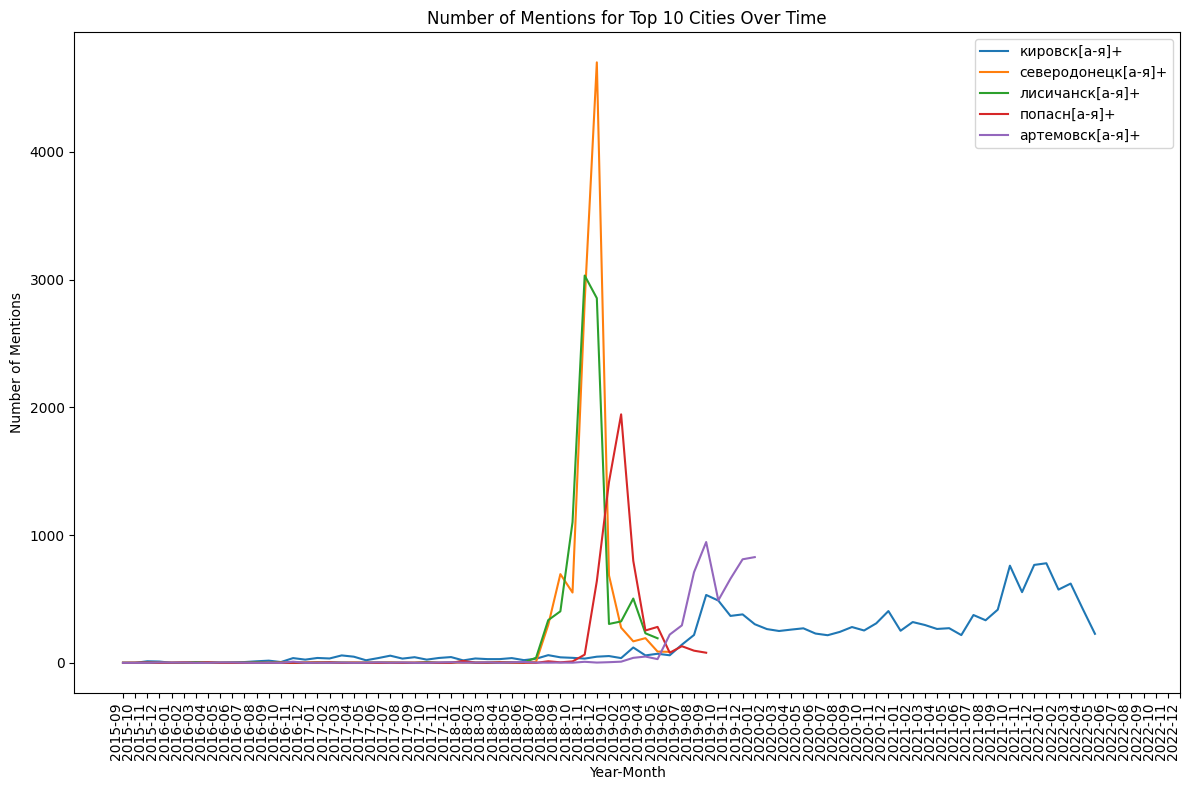

In [59]:
plt.figure(figsize=(12, 8))
for city in top_cities[5:10]:
    city_data = top_cities_data[top_cities_data['city'] == city]
    city_data.groupby(['year', 'month'])['city'].count().plot(label=city)

plt.xlabel('Year-Month')
plt.ylabel('Number of Mentions')
plt.title('Number of Mentions for Top 10 Cities Over Time')
plt.legend()
plt.xticks(rotation=90, ha='right')

unique_dates = sorted(top_cities_data.groupby(['year', 'month']).size().index)
plt.gca().set_xticks(range(len(unique_dates)))
plt.gca().set_xticklabels([f"{year}-{month:02d}" for year, month in unique_dates])
plt.tight_layout()
plt.show()

## Embeddings on messages


Analyzing propaganda through word embeddings provides a nuanced understanding of the semantic relationships between words. This approach enables the detection of code words, buzzwords, and persuasive techniques employed in propaganda messages. By exploring similarities between terms, it aids in identifying key themes, comparing language use across sources, and gaining insights into framing strategies. Word embeddings offer a sophisticated means of contextual analysis, enhancing the interpretation of propaganda messaging beyond traditional frequency-based methods.

In [ ]:
api_key = 'key'
openai.api_key = api_key

sentences = []

for i in range(10000):
  sentences.append(all_text.iloc[i]['message'])

In [ ]:
db = Chroma.from_texts(sentences, OpenAIEmbeddings(openai_api_key=api_key))

In [ ]:
db.similarity_search('Россия проиграет, если не договорится')

[Document(page_content='Трудно не согласиться'),
 Document(page_content='Кучно пошло сегодня про переговоры. Запад должен вести переговоры с Россией об окончании войны, даже если они приведут к замороженному конфликту, считает министр обороны Румынии Дынку'),
 Document(page_content='Вот оно как :)\n\nПодоляк: Переговоры с Россией не выгодны как для Украины, так и для Европы'),
 Document(page_content='Только он забыл добавить, что если хутор продолжит воевать - его опять же не будет.\n\nСтолтенберг: Если Россия прекратит воевать - не будет войны, если Украина прекратит воевать - не будет Украины')]